In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import the necessary packages
import os
# define the base path to the input dataset and then use it to derive
# the path to the images directory and annotation CSV file
BASE_PATH = "/content/drive/MyDrive/DataScience/ObjDectection_Caltech_Airplanes/dataset/"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "images"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "airplanes.csv"])

In [3]:
# !unzip "/content/drive/MyDrive/DataScience/ObjDectection_Caltech_Airplanes/dataset/images.zip" -d "/content/drive/MyDrive/DataScience/ObjDectection_Caltech_Airplanes/dataset/"

In [4]:
# define the path to the base output directory
BASE_OUTPUT = "/content/drive/MyDrive/DataScience/ObjDectection_Caltech_Airplanes/output/"
# define the path to the output serialized model, model training plot,
# and testing image filenames
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_FILENAMES = os.path.sep.join([BASE_OUTPUT, "test_images.txt"])

In [5]:
INIT_LR = 1e-4
NUM_EPOCHS = 25
BATCH_SIZE = 32

In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [7]:
print("[INFO] loading dataset...")
rows = open(ANNOTS_PATH).read().strip().split("\n")
# initialize the list of data (images), our target output predictions
# (bounding box coordinates), along with the filenames of the
# individual images
data = []
targets = []
filenames = []

[INFO] loading dataset...


In [9]:
for row in rows:
  row = row.split(',')
  (filename, startX, startY, endX, endY) = row
  imagepath = os.path.sep.join([IMAGES_PATH, filename])
  image = cv2.imread(imagepath)
  (h, w) = image.shape[:2]

  startX = float(startX) / w
  startY = float(startY) / h
  endX = float(endX) / w
  endY = float(endY) / h

  image = load_img(imagepath, target_size=(224, 224))
  image = img_to_array(image)

  data.append(image)
  targets.append((startX, startY, endX, endY))
  filenames.append(filename)


In [10]:
data = np.array(data, dtype='float32') / 255.0
targets = np.array(targets, dtype='float32')

split = train_test_split(data, targets, filenames, test_size=0.1, random_state=42)

(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainfilenames, testfilenames) = split[4:]

print("Saving test filenames")
f = open(TEST_FILENAMES, "w")
f.write('\n'.join(testfilenames))
f.close()
                                

Saving test filenames


In [11]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

vgg_model.trainable = False

flatten = vgg_model.output
flatten = Flatten()(flatten)

bboxhead = Dense(128, activation = "relu")(flatten)
bboxhead = Dense(64, activation="relu")(bboxhead)
bboxhead = Dense(32, activation="relu")(bboxhead)
bboxhead = Dense(4, activation="sigmoid")(bboxhead)

model = Model(inputs=vgg_model.input, outputs=bboxhead)

58900480/58889256 [==============================] - 0s 0us/step


In [12]:
opt = Adam(lr=INIT_LR)
model.compile(loss="mse", optimizer=opt)
print(model.summary())
# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/25
23/23 [==============================] - 32s 526ms/step - loss: 0.0113 - val_loss: 0.0042
Epoch 2/25
23/23 [==============================] - 6s 268ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 3/25
23/23 [==============================] - 6s 267ms/step - loss: 9.9962e-04 - val_loss: 8.5756e-04
Epoch 4/25
23/23 [==============================] - 6s 268ms/step - loss: 8.0127e-04 - val_loss: 7.5006e-04
Epoch 5/25
23/23 [==============================] - 6s 268ms/step - loss: 6.3330e-04 - val_loss: 6.2659e-04
Epoch 6/25
23/23 [==============================] - 6s 268ms/step - loss: 5.2947e-04 - val_loss: 6.3631e-04
Epoch 7/25
23/23 [==============================] - 6s 266ms/step - loss: 4.6567e-04 - val_loss: 5.9822e-04
Epoch 8/25
23/23 [==============================] - 6s 267ms/step - loss: 4.0513e-04 - val_loss: 6.2109e-04
Epoch 9/25
23/23 [==============================] - 6s 267ms/step - loss: 3.5876e-04 - val_loss: 6.2500e-04
Epoch 10/25
23/23 [========================

In [13]:
print("[INFO] saving object detector model...")
model.save(MODEL_PATH, save_format="h5")

[INFO] saving object detector model...


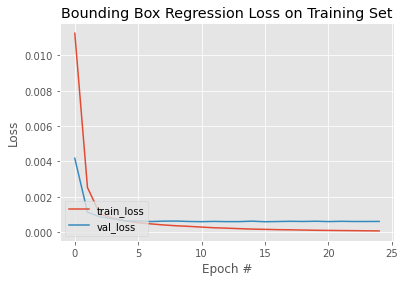

In [14]:
# plot the model training history
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)